In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from collections import Counter

In [2]:
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load the data
json_data = []
with open('DeteksiSarkasme.json', 'r') as f:
    for line in f:
        if line.strip():
            json_data.append(eval(line))

In [5]:
# Convert to pandas DataFrame
df = pd.DataFrame(json_data)
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (26709, 3)
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [6]:
# Count the classes
class_counts = df['is_sarcastic'].value_counts()
print("\nClass distribution:")
print(f"Non-sarcastic headlines: {class_counts[0]}")
print(f"Sarcastic headlines: {class_counts[1]}")


Class distribution:
Non-sarcastic headlines: 14985
Sarcastic headlines: 11724


In [7]:
# Basic text preprocessing
def preprocess_text(text):
    text = text.lower()
    # Remove any extra whitespace
    text = ' '.join(text.split())
    return text

df['headline'] = df['headline'].apply(preprocess_text)

In [8]:
# Tokenization and vocabulary building
def build_vocab(texts, max_words=10000):
    words = []
    for text in texts:
        words.extend(text.split())

    counter = Counter(words)
    vocab = ['<PAD>', '<UNK>']
    vocab.extend([word for word, count in counter.most_common(max_words-2)])
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    return vocab, word_to_idx

vocab, word_to_idx = build_vocab(df['headline'])
print(f"\nVocabulary size: {len(vocab)}")


Vocabulary size: 10000


In [9]:
# Convert text to sequences
def text_to_sequence(text, word_to_idx, max_len=30):
    words = text.split()
    sequence = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in words]

    # Pad or truncate
    if len(sequence) < max_len:
        sequence = sequence + [word_to_idx['<PAD>']] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]

    return sequence

In [10]:
# Create dataset
class SarcasmDataset(Dataset):
    def __init__(self, headlines, labels):
        self.headlines = headlines
        self.labels = labels

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        headline = torch.tensor(self.headlines[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return headline, label

In [11]:
# Convert all headlines to sequences
max_len = 30
sequences = df['headline'].apply(lambda x: text_to_sequence(x, word_to_idx, max_len)).tolist()

In [12]:
# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    sequences, df['is_sarcastic'].values, test_size=0.2, random_state=42, stratify=df['is_sarcastic'].values
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 16025 samples
Validation set: 5342 samples
Test set: 5342 samples


In [13]:
# Create datasets and dataloaders
train_dataset = SarcasmDataset(X_train, y_train)
val_dataset = SarcasmDataset(X_val, y_val)
test_dataset = SarcasmDataset(X_test, y_test)

In [14]:
# Define our Deep RNN model
class DeepRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # Deep LSTM with multiple stacked layers
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=False,  # Not bidirectional (this is the key change)
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)

        # No multiplier needed since we're not using bidirectional layers
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text: [batch size, sent len]

        embedded = self.dropout(self.embedding(text))
        # embedded: [batch size, sent len, emb dim]

        # LSTM
        output, (hidden, cell) = self.rnn(embedded)
        # output: [batch size, sent len, hid dim]
        # hidden: [n layers, batch size, hid dim]

        # Use the final hidden state from the last layer
        hidden = hidden[-1, :, :]
        # hidden: [batch size, hid dim]

        return self.fc(self.dropout(hidden))

In [15]:
# Modified hyperparameter combinations for deep RNN
deep_rnn_hyperparameters = [
    {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001},
    {'embedding_dim': 200, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001},
    {'embedding_dim': 300, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001},
    {'embedding_dim': 100, 'hidden_dim': 256, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001},
    {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001},
    {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 4, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001},
    {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.5, 'batch_size': 32, 'learning_rate': 0.001},
    {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.001},
    {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.01},
    {'embedding_dim': 200, 'hidden_dim': 256, 'n_layers': 3, 'dropout': 0.5, 'batch_size': 64, 'learning_rate': 0.001}
]

In [16]:
# Function for training and evaluation
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):
        start_time = time.time()

        # Training
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        for batch in train_loader:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            optimizer.zero_grad()

            predictions = model(text).squeeze(1)

            loss = criterion(predictions, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float().sum()
            epoch_acc += correct.item()

        # Calculate training metrics
        train_loss = epoch_loss / len(train_loader)
        train_accuracy = epoch_acc / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        # Validation
        model.eval()
        epoch_val_loss = 0
        epoch_val_acc = 0

        with torch.no_grad():
            for batch in val_loader:
                text, labels = batch
                text, labels = text.to(device), labels.to(device)

                predictions = model(text).squeeze(1)

                loss = criterion(predictions, labels)

                epoch_val_loss += loss.item()

                predicted_classes = torch.round(torch.sigmoid(predictions))
                correct = (predicted_classes == labels).float().sum()
                epoch_val_acc += correct.item()

        # Calculate validation metrics
        val_loss = epoch_val_loss / len(val_loader)
        val_accuracy = epoch_val_acc / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        end_time = time.time()

        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'Time: {end_time - start_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}')
        print('-' * 50)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best-deep-rnn-model.pt')

    return train_losses, val_losses, train_acc, val_acc

In [17]:
# Function for evaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()

    all_predictions = []
    all_labels = []
    test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text).squeeze(1)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            # Get probabilities and predictions
            probs = torch.sigmoid(predictions)
            predicted_classes = torch.round(probs)

            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_predictions)
    prec = precision_score(all_labels, all_predictions)
    rec = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    # ROC AUC might give warning if there's only one class in predictions
    try:
        auc = roc_auc_score(all_labels, all_predictions)
    except:
        auc = 0

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    metrics = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'test_loss': test_loss / len(test_loader)
    }

    return metrics

In [18]:
# Limited hyperparameter tuning for Deep RNN
def deep_rnn_hyperparameter_tuning():
    best_val_loss = float('inf')
    best_params = {}
    results = []

    # Test each hyperparameter combination
    for i, params in enumerate(deep_rnn_hyperparameters):
        print(f"\nTesting hyperparameter combination {i+1}/{len(deep_rnn_hyperparameters)}:")
        print(f"Parameters: {params}")

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'])

        # Initialize model with Deep RNN
        model = DeepRNN(
            vocab_size=len(vocab),
            embedding_dim=params['embedding_dim'],
            hidden_dim=params['hidden_dim'],
            output_dim=1,
            n_layers=params['n_layers'],
            dropout=params['dropout'],
            pad_idx=word_to_idx['<PAD>']
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.BCEWithLogitsLoss()

        # Train for a small number of epochs for hyperparameter tuning
        _, val_losses, _, val_acc = train_model(
            model, train_loader, val_loader, optimizer, criterion, epochs=3
        )

        # Get the final validation loss
        final_val_loss = val_losses[-1]

        # Record results
        result = params.copy()
        result['val_loss'] = final_val_loss
        result['val_accuracy'] = val_acc[-1]
        results.append(result)

        # Check if this is the best model
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params.copy()

    return best_params, results

In [19]:
# Run hyperparameter tuning for Deep RNN
print("\nStarting Deep RNN hyperparameter tuning...")
best_params, tuning_results = deep_rnn_hyperparameter_tuning()
print(f"Best hyperparameters: {best_params}")


Starting Deep RNN hyperparameter tuning...

Testing hyperparameter combination 1/10:
Parameters: {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001}
Epoch: 1/3
Time: 3.74s
Train Loss: 0.6796 | Train Acc: 0.5681
Val Loss: 0.6118 | Val Acc: 0.6775
--------------------------------------------------
Epoch: 2/3
Time: 2.06s
Train Loss: 0.5884 | Train Acc: 0.6904
Val Loss: 0.5383 | Val Acc: 0.7145
--------------------------------------------------
Epoch: 3/3
Time: 2.62s
Train Loss: 0.5452 | Train Acc: 0.7377
Val Loss: 0.5008 | Val Acc: 0.7673
--------------------------------------------------

Testing hyperparameter combination 2/10:
Parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001}
Epoch: 1/3
Time: 2.24s
Train Loss: 0.6668 | Train Acc: 0.6057
Val Loss: 0.6509 | Val Acc: 0.6466
--------------------------------------------------
Epoch: 2/3
Time: 4.21s
Tra

In [20]:
# Show tuning results sorted by validation loss
df_results = pd.DataFrame(tuning_results)
print("\nHyperparameter tuning results:")
print(df_results.sort_values('val_loss').head(10))


Hyperparameter tuning results:
   embedding_dim  hidden_dim  n_layers  dropout  batch_size  learning_rate  \
5            100         128         4      0.3          32          0.001   
0            100         128         2      0.3          32          0.001   
9            200         256         3      0.5          64          0.001   
6            100         128         2      0.5          32          0.001   
7            100         128         2      0.3          64          0.001   
3            100         256         2      0.3          32          0.001   
2            300         128         2      0.3          32          0.001   
4            100         128         3      0.3          32          0.001   
1            200         128         2      0.3          32          0.001   
8            100         128         2      0.3          32          0.010   

   val_loss  val_accuracy  
5  0.493149      0.757581  
0  0.500844      0.767316  
9  0.593558      0.661737

In [21]:
# Train the final Deep RNN model with the best hyperparameters
print("\nTraining final Deep RNN model with best hyperparameters...")
final_model = DeepRNN(
    vocab_size=len(vocab),
    embedding_dim=best_params['embedding_dim'],
    hidden_dim=best_params['hidden_dim'],
    output_dim=1,
    n_layers=best_params['n_layers'],
    dropout=best_params['dropout'],
    pad_idx=word_to_idx['<PAD>']
).to(device)

final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.BCEWithLogitsLoss()


Training final Deep RNN model with best hyperparameters...


In [22]:
# Create data loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

In [23]:
# Train the final model
train_losses, val_losses, train_acc, val_acc = train_model(
    final_model, train_loader, val_loader, final_optimizer, criterion, epochs=10
)

Epoch: 1/10
Time: 2.95s
Train Loss: 0.6863 | Train Acc: 0.5589
Val Loss: 0.6831 | Val Acc: 0.5610
--------------------------------------------------
Epoch: 2/10
Time: 2.54s
Train Loss: 0.6802 | Train Acc: 0.5584
Val Loss: 0.6813 | Val Acc: 0.5610
--------------------------------------------------
Epoch: 3/10
Time: 2.59s
Train Loss: 0.6767 | Train Acc: 0.5609
Val Loss: 0.6809 | Val Acc: 0.5610
--------------------------------------------------
Epoch: 4/10
Time: 2.53s
Train Loss: 0.6592 | Train Acc: 0.5953
Val Loss: 0.6071 | Val Acc: 0.6541
--------------------------------------------------
Epoch: 5/10
Time: 3.19s
Train Loss: 0.5501 | Train Acc: 0.7133
Val Loss: 0.4887 | Val Acc: 0.7557
--------------------------------------------------
Epoch: 6/10
Time: 2.56s
Train Loss: 0.4474 | Train Acc: 0.7865
Val Loss: 0.4355 | Val Acc: 0.7982
--------------------------------------------------
Epoch: 7/10
Time: 2.52s
Train Loss: 0.3806 | Train Acc: 0.8310
Val Loss: 0.3956 | Val Acc: 0.8242
--------

In [24]:
# Load the best model
final_model.load_state_dict(torch.load('best-deep-rnn-model.pt'))

<All keys matched successfully>

In [25]:
# Evaluate on test set
test_metrics = evaluate_model(final_model, test_loader, criterion)

In [26]:
# Print metrics
print("\nTest Metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
print(f"AUC: {test_metrics['auc']:.4f}")
print(f"Test Loss: {test_metrics['test_loss']:.4f}")


Test Metrics:
Accuracy: 0.8377
Precision: 0.8202
Recall: 0.8072
F1 Score: 0.8137
AUC: 0.8344
Test Loss: 0.3935


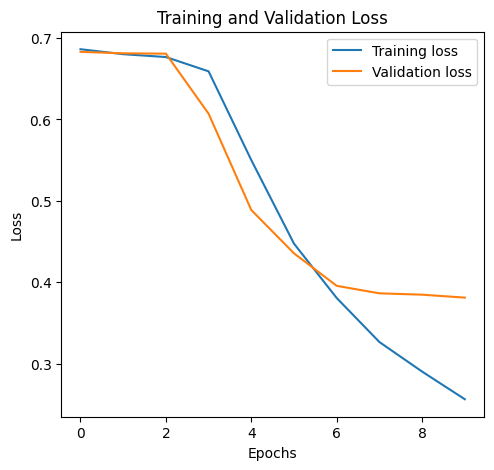

In [27]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

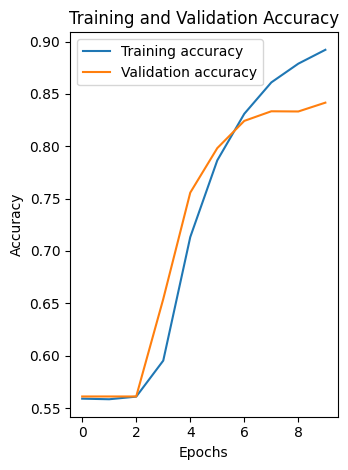

In [28]:
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('deep_rnn_training_curves.png')
plt.show()

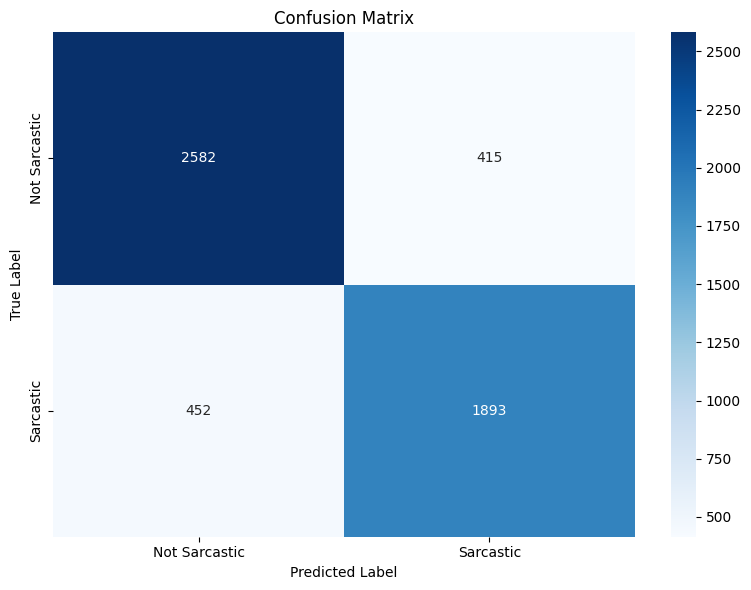

In [29]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    test_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Sarcastic', 'Sarcastic'],
    yticklabels=['Not Sarcastic', 'Sarcastic']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('deep_rnn_confusion_matrix.png')
plt.show()

In [30]:
# Example predictions
def predict_sarcasm(headline, model, word_to_idx, max_len=30):
    model.eval()
    processed_headline = preprocess_text(headline)
    sequence = text_to_sequence(processed_headline, word_to_idx, max_len)
    tensor = torch.tensor([sequence], dtype=torch.long).to(device)

    with torch.no_grad():
        prediction = model(tensor).squeeze(1)
        probability = torch.sigmoid(prediction).item()

    return probability

# Test with some examples
example_headlines = [
    "former versace store clerk sues over secret 'black code' for minority shoppers",
    "mom starting to fear son's web series closest thing she will have to grandchild",
    "top snake handler leaves sinking huckabee campaign"
]

print("\nExample predictions:")
for headline in example_headlines:
    prob = predict_sarcasm(headline, final_model, word_to_idx)
    prediction = "Sarcastic" if prob > 0.5 else "Not Sarcastic"
    print(f"Headline: {headline}")
    print(f"Prediction: {prediction} (probability: {prob:.4f})")
    print("-" * 50)


Example predictions:
Headline: former versace store clerk sues over secret 'black code' for minority shoppers
Prediction: Not Sarcastic (probability: 0.0916)
--------------------------------------------------
Headline: mom starting to fear son's web series closest thing she will have to grandchild
Prediction: Sarcastic (probability: 0.5968)
--------------------------------------------------
Headline: top snake handler leaves sinking huckabee campaign
Prediction: Sarcastic (probability: 0.9290)
--------------------------------------------------
